# Imports

In [165]:
# !pip3 install openpyxl --break-system-packages

In [164]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer

# Helper Functions

In [148]:
def get_feature_vector(fname):
    # fname must be an excel path in .xlsx according to the template
    # read the excel table in as a proper dataframe
    # turn all the 1's into the number of the bucket
    df_tmp = pd.read_excel(fname)
    colnames = df_tmp.iloc[1].values # get the bucket names (not actually necessary)
    df = df_tmp.iloc[2:56] # only get the values, cut out the readability part of the excel file
    df.columns = colnames

    assert all(df.apply(lambda x: sum(x[1:]), axis=1) == 1) # ensure that each value is only in one bucket

    bin_scores = np.array(range(9, 0, -1)) # single value for each bin
    bin_scores_df = df.apply(lambda x: sum(x[1:] * bin_scores), axis=1) # get the bin score for the culture value
    feature_vector = dict(zip(df.iloc[:,0], bin_scores_df)) # associate value w/ score
    return feature_vector

In [155]:
def clean_for_factor_analysis(df, verbose=True):
    original_cols = df.columns.tolist()

    # Drop zero-variance columns
    stds = df.std(ddof=0)
    zero_var_cols = stds[stds == 0].index.tolist()
    df_clean = df.drop(columns=zero_var_cols)

    # Drop duplicated columns
    dup_cols = df_clean.T.duplicated()
    duplicated_columns = df_clean.columns[dup_cols].tolist()
    df_clean = df_clean.loc[:, ~dup_cols]

    # Drop perfectly correlated columns
    corr = df_clean.corr()
    upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    perfect_corr_cols = [column for column in upper_tri.columns if any(upper_tri[column].abs() == 1)]
    df_clean = df_clean.drop(columns=perfect_corr_cols)

    if verbose:
        print(f"🧹 Original columns: {len(original_cols)}")
        print(f"🧯 Dropped zero-variance columns: {len(zero_var_cols)}")
        print(f"📄 Dropped duplicated columns: {len(duplicated_columns)}")
        print(f"🔁 Dropped perfectly correlated columns: {len(perfect_corr_cols)}")
        print(f"✅ Final columns: {df_clean.shape[1]}")

    return df_clean


# Prepare Data

In [149]:
directory = 'data/'

features = []
for fname_suffix in os.listdir(directory):
    features.append(get_feature_vector(f'{directory}{fname_suffix}'))
data = pd.DataFrame(features)

# PCA
- PCA is just to get the number of 

In [150]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Run PCA
pca = PCA()
pca.fit(data_scaled)

PCA()

In [151]:
# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
# Print explained variance
print("Explained Variance Ratios:", explained_variance)
print("Cumulative Explained Variance:", cumulative_variance)

Explained Variance Ratios: [3.16288979e-01 2.37882465e-01 2.01604664e-01 1.50400373e-01
 9.38235197e-02 4.04749130e-33]
Cumulative Explained Variance: [0.31628898 0.55417144 0.75577611 0.90617648 1.         1.        ]


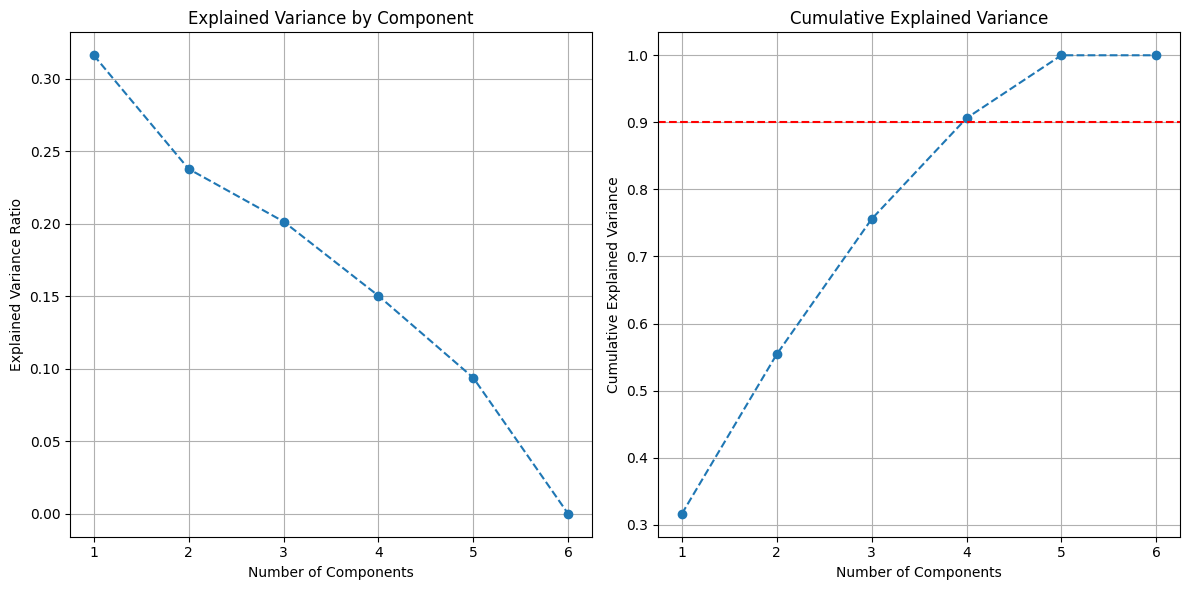

In [152]:
# Plotting Explained Variance
plt.figure(figsize=(12, 6))

# Explained Variance Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid()

# Cumulative Explained Variance Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='--')  # Adjust threshold as needed
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()

plt.tight_layout()
plt.show()


In [166]:
# unnecessary, but here in case I need it later. Maybe I can do more w/ PCA
num_components = 4
pca = PCA(n_components=num_components)
components = pca.fit_transform(data_scaled)

In [156]:
data_fa = clean_for_factor_analysis(data)

🧹 Original columns: 54
🧯 Dropped zero-variance columns: 0
📄 Dropped duplicated columns: 0
🔁 Dropped perfectly correlated columns: 0
✅ Final columns: 54


In [157]:
# Apply Varimax rotation
fa = FactorAnalyzer(rotation='varimax', n_factors=num_components)
fa.fit(data_fa)

FactorAnalyzer(n_factors=4, rotation='varimax', rotation_kwargs={})

In [159]:
# Apply Varimax rotation
fa = FactorAnalyzer(rotation='varimax', n_factors=num_components)
fa.fit(data_scaled)

# Get loadings
loadings = fa.loadings_

In [160]:
# Print the loadings
loadings_df = pd.DataFrame(loadings, index=data.columns, columns=[f'Factor {i+1}' for i in range(num_components)])
print("Loadings after Varimax Rotation:")
loadings_df

Loadings after Varimax Rotation:


,Factor 1,Factor 2,Factor 3,Factor 4
Flexibility,-0.273217,0.392252,0.105537,-0.574239
Adaptability,0.815889,0.065078,-0.443311,-0.238149
Stability,0.941217,0.129090,-0.303399,-0.048158
Predictability,0.910897,-0.382769,-0.018033,-0.055085
Being innovative,0.904307,0.058412,0.358956,0.231578
Being quick to take advantage of opportunities,0.715586,-0.405909,0.557909,-0.002281
A willingness to experiment,0.693375,0.081738,0.200453,0.688582
Risk taking,0.347611,-0.027241,0.472027,0.808540
Being careful,0.800196,-0.297133,0.098365,0.464013
Autonomy,-0.022986,0.019520,-0.954914,-0.188210


In [161]:
# Function to highlight values
def highlight_significant(s):
    return ['font-weight: bold' if abs(value) > 0.4 else '' for value in s]

In [162]:
styled_df = loadings_df.style.apply(highlight_significant, axis=0)
styled_df

,Factor 1,Factor 2,Factor 3,Factor 4
Flexibility,-0.273217,0.392252,0.105537,-0.574239
Adaptability,0.815889,0.065078,-0.443311,-0.238149
Stability,0.941217,0.129090,-0.303399,-0.048158
Predictability,0.910897,-0.382769,-0.018033,-0.055085
Being innovative,0.904307,0.058412,0.358956,0.231578
Being quick to take advantage of opportunities,0.715586,-0.405909,0.557909,-0.002281
A willingness to experiment,0.693375,0.081738,0.200453,0.688582
Risk taking,0.347611,-0.027241,0.472027,0.808540
Being careful,0.800196,-0.297133,0.098365,0.464013
Autonomy,-0.022986,0.019520,-0.954914,-0.188210


In [163]:
for i in range(num_components):
    factor_name = f'Factor {i+1}'
    vector = loadings_df[(loadings_df[factor_name] < -0.4) | (loadings_df[factor_name] > 0.4)][factor_name].sort_values(ascending=False)
    print(vector)
    print('\n')

Being easy going                                  0.970985
Stability                                         0.941217
Predictability                                    0.910897
Being innovative                                  0.904307
Being calm                                        0.894783
Adaptability                                      0.815889
Being careful                                     0.800196
Emphasizing a single culture throughout           0.753642
Being quick to take advantage of opportunities    0.715586
A willingness to experiment                       0.693375
Confronting conflict directly                     0.593766
Tolerance                                         0.517641
Being precise                                     0.424361
Paying attention to detail                       -0.410793
Opportunities for professional growth            -0.418193
Security of employment                           -0.444622
Being results oriented                           -0.5539